In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import scipy.stats
import math


from cycler import cycler
## Create list with standard colors:
color_dict_stand = {}
for ii, x in enumerate(plt.rcParams['axes.prop_cycle']()):
    color_dict_stand[ii] = x['color']
    if ii > 8:
        break  # after 8 it repeats (for ever)
plt.rcParams['axes.prop_cycle'] = cycler(color=sns.color_palette('colorblind'))

## 2 cells example:

Assume the covariance matrix $C$ between two neurons:
$\begin{equation}
C = 
\begin{pmatrix}
1 & c \\
c & k
\end{pmatrix}
    \end{equation}$.
The the pearson correlation $r_{12} = \frac{c}{\sqrt{k}}$. The explained variance of the first eigenvector can be calculated. 
Easier way to look at it: assume $k=1$ (because neuron 1 and 2 come from the same distribution; or by rescaling neuron 2). Then:
$\begin{equation}
C = 
\begin{pmatrix}
1 & c \\
c & 1
\end{pmatrix}
    \end{equation}$.
And it follows that the eigenvalues $\lambda$ are:
$\begin{equation}
(1 - \lambda)^2 - c^2 = 0 \iff \lambda = 1 \pm c
\end{equation}$.
Hence the explained variance by the 1st PC is $EVar = \frac{1 + |c|}{2}$ and the pearson correlation coefficient is $r = c$.

/home/tplas/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


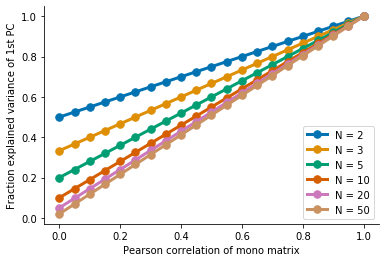

In [3]:
def pearson_ev_mono_mat(n=50, c=0.5):
    '''Compute pearson corr and 1st EV of matrix with same correlation
    value for all off-diagonal elements'''
    mat = np.zeros((n, n)) + c
    np.fill_diagonal(mat, 1)  # set diag to 1 
    evals, evects = np.linalg.eig(mat)
    evar_1 = np.max(evals) / np.sum(evals)
    return evar_1

## testing some analytic results with N=2:
assert pearson_ev_mono_mat(n=2, c=0.5) == pearson_ev_mono_mat(n=2, c=-0.5)
assert [np.isclose(pearson_ev_mono_mat(n=2, c=np.abs(x)), 
                   (1 + np.abs(x)) / 2) for x in [np.random.randn()]][0]  # assert analytical derivation above

c_arr = np.linspace(0, 1, 21)
ax_mono = plt.subplot(111)
for i_n, n in enumerate([2, 3, 5, 10, 20, 50]):
    ev_arr = [pearson_ev_mono_mat(c=x, n=n) for x in c_arr]
    ax_mono.plot(c_arr, ev_arr, marker='.', linewidth=3, 
                 markersize=15, label=f'N = {n}')
ax_mono.legend(loc='lower right')
ax_mono.set_xlabel('Pearson correlation of mono matrix')
ax_mono.set_ylabel('Fraction explained variance of 1st PC');
ax_mono.spines['top'].set_visible(False)
ax_mono.spines['right'].set_visible(False)

## N > 2 with uniform c
See plot above. Blue corresponds to the N=2 derivation. N=3 results in a third order polynomial (which is a pain), larger polynomials can generally not be solved. However, we can observe the eigenvector: $v_1 = (1, 1, 1, 1 .. 1)$. Therefore: 
$\begin{equation}
C \cdot v_1 = (1 + (N-1) c) v_1
\end{equation}$.

This is also shown in the graph for $c > 0$. So this seems to be the largest Eigenvalue. The $c > 0$ is because for negative $c$ this no longer the largest (positive) eigenvalue. But also then the matrix is not defined to be semi-definite positive anymore, which is a property of covariance matrices. 

In [4]:
def pearson_ev_cvals_mat(c_vals, n=50):
    '''Compute pearson corr and 1st EV of matrix with same correlation
    value for all off-diagonal elements'''
    mat = np.ones((n, n)) # diag to 1
    upper_triu_inds = np.triu_indices_from(mat, k=1)  # top off-diagonal triangle
    lower_triu_inds = (upper_triu_inds[1], upper_triu_inds[0])
    n_offdiag = len(upper_triu_inds[0])
    assert n_offdiag == len(c_vals), f'{n_offdiag} needed but {len(c_vals)} given'
    mat[upper_triu_inds] = c_vals
    mat[lower_triu_inds] = c_vals  # fill matrix with symm corr values
    mean_c = np.mean(c_vals)  # mean corr (only if diagonal == 1)
    evals, evects = np.linalg.eig(mat)
    evar_1 = np.max(evals) / np.sum(evals)
    return (mean_c, evar_1)

def pearson_ev_unif_mat(n=50, u_min=0):
    n_offdiag = int((n - 1) * (n) / 2)
#     print(n_offdiag)
    c_vals = np.random.uniform(low=u_min, high=1, size=n_offdiag)
    return pearson_ev_cvals_mat(c_vals=c_vals, n=n)
    
mean_c, evar_1 = pearson_ev_unif_mat(n=100)
print(f'Correlation values drawn from uniform distr U(0, 1) of a 100x100 Covar mat:')
print(f'Mean Pearson corr: {np.round(mean_c, 3)}')
print(f'Explained var by 1st PC: {np.round(evar_1, 3)}')

Correlation values drawn from uniform distr U(0, 1) of a 100x100 Covar mat:
Mean Pearson corr: 0.499
Explained var by 1st PC: 0.505


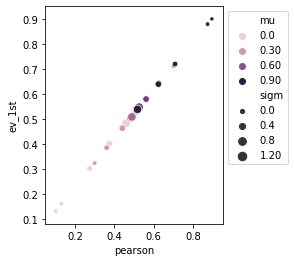

In [5]:
def rejection_sampling_gauss_interval(n_points=100, mu=0.5, sigma=0.2, 
                                      int_min=0, int_max=1):
    '''Function that samples from Gauss within an interval using (recurrent)
    rejection sampling'''
    
    data = np.random.normal(loc=mu, scale=sigma, size=n_points)
    
    inds_outside = np.where(np.logical_or(data < int_min, 
                                          data > int_max))[0]
    n_loops = 0
    while len(inds_outside) > 0: # while points outside 
        n_loops += 1
        data[inds_outside] = np.random.normal(loc=mu, scale=sigma,
                                              size=len(inds_outside))
        
        inds_outside = np.where(np.logical_or(data < int_min, 
                                              data > int_max))[0]
       
    assert np.min(data) >= int_min
    assert np.max(data) <= int_max
#     print(f'Solved in {n_loops} loops')
    return data
    
def pearson_ev_gauss_mat(n=1000, mu=0.5, sigma=0.1, int_min=0):
    n_offdiag = int((n - 1) * (n) / 2)
    data = rejection_sampling_gauss_interval(n_points=n_offdiag, mu=mu, 
                                             sigma=sigma, int_min=int_min)
    return pearson_ev_cvals_mat(c_vals=data, n=n)
    

def create_gauss_df(sig_array=np.array([0.05, 0.1, 0.3, 0.5, 1]), 
                    mu_array=np.array([0.1, 0.3, 0.5, 0.7, 0.9]), int_min=0):
    n_sim = int(len(sig_array) * len(mu_array))
    gauss_df = pd.DataFrame({x: np.zeros(n_sim) for x in ['mu', 'sigma', 'pearson', 
                                                          'ev_1st', 'n_points']})
    i_sim = 0 
    n_points = 30
    for i_mu, mu in enumerate(mu_array):
        for i_sig, sig in enumerate(sig_array):
            mean_c, ev = pearson_ev_gauss_mat(n=n_points, mu=mu, sigma=sig, int_min=int_min)
            gauss_df['mu'].iat[i_sim] = mu
            gauss_df['sigma'].iat[i_sim] = sig
            gauss_df['pearson'].iat[i_sim] = mean_c
            gauss_df['ev_1st'].iat[i_sim] = ev
            gauss_df['n_points'].iat[i_sim] = n_points
            i_sim += 1
            
    return gauss_df
    
df_gauss = create_gauss_df(int_min=0, mu_array=np.array([0.1, 0.3, 0.5, 0.7, 0.9]))
# print(df_gauss)
plt.rcParams['figure.figsize'] = (7, 4)

# ax_distr = plt.subplot(121)
# t_arr = np.linspace(0, 1, 101)

# for i_sim in range(len(df_gauss)):
#     rv = scipy.stats.norm(loc=df_gauss['mu'].iat[i_sim], 
#                           scale=df_gauss['sigma'].iat[i_sim])
#     ax_distr.plot(rv.pdf(t_arr), linewidth=df_gauss['sigma'].iat[i_sim] * 5,
#                   c=)


ax_results = plt.subplot(122)
plot_gauss = sns.scatterplot(data=df_gauss, x='pearson', y='ev_1st', 
                             hue='mu', size='sigma', ax=ax_results)
ax_results.legend(bbox_to_anchor=(1, 1))
leg = plot_gauss.legend_
for t in leg.texts:
    # truncate label text to 4 characters
    t.set_text(t.get_text()[:4])

## N > 2 with varying c per pair
Simulations above show that with $c$ drawn from Gaussian, for varying $\mu$ and $\sigma$, pearson correlation remains approximately equal to $Expl Var$. Note that only positive values are used here (with rejection sampling). When using negative values, one has to ensure the matrix remains positive semi-definite - a property of covariance matrices ensuring that all its eigenvalues are real and non-negative.

Hence below we generate a PSD matrix (by generating (potentially) correlated gaussian processes, and taking covariance) - note that any matrix $M$ can create a PSD matrix by $M M^T$.

See the Gershgorin circle re upper bound on eigenvalue (= largest row sum) https://en.wikipedia.org/wiki/Gershgorin_circle_theorem

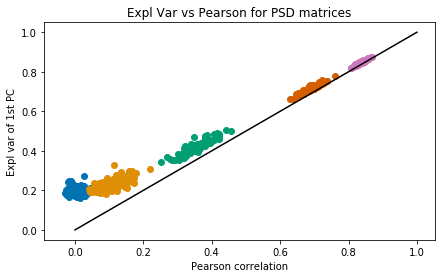

In [121]:
def rbf_kernel(x1, x2, variance = 1): # https://gist.github.com/neubig/e859ef0cc1a63d1c2ea4
    return math.exp(-1 * ((x1-x2) ** 2) / (2*variance))

def gram_matrix(xs):
    return [[rbf_kernel(x1,x2) for x2 in xs] for x1 in xs]

def create_psd_values(n, t_points=None, sin_scale=0, plot=False):
    if t_points is None:
        t_points = int(1.5 * n)
    xs = np.arange(0, t_points / 10, 0.1)
    mean= np.sin(xs) * sin_scale  # simple way to set global correlation
    gram = gram_matrix(xs)
    
    act_mat = np.zeros((n, t_points))
    for neuron in range(n):
        act_mat[neuron, :] = np.random.multivariate_normal(mean, gram)
#         act_mat[neuron, :] = act_mat[neuron, :] - np.mean(act_mat[neuron, :])
    cov = np.cov(act_mat)
#     cov = np.dot(act_mat, act_mat.transpose()) / t_points
    pearson = np.corrcoef(act_mat)
    assert cov.shape[0] == cov.shape[1] and cov.shape[0] == n and cov.shape == pearson.shape
    if plot:
        plt.subplot(121)
        plt.plot(act_mat.T)
        plt.xlabel('time'); plt.ylabel('activity')
        plt.title('dynamic activity')
 
        plt.subplot(122)
        sns.heatmap(cov)
        plt.title('Covariance matrix')
    return cov, pearson
    
def pearson_ev_psd_mat(n=1000, t=None, sin_scale=0, verbose=0):
    n_offdiag = int((n - 1) * (n) / 2)
    cov, pearson = create_psd_values(n=n, t_points=t, sin_scale=sin_scale)
    c_vals = cov[np.triu_indices_from(cov, k=1)]  # off diagonal elements
    
    mean_c = np.mean(pearson[np.triu_indices_from(cov, k=1)])
    if verbose > 0:
        print(f'Smallest covar {np.round(np.min(cov), 3)}, largest: {np.round(np.max(cov), 3)}')
        print(f'Smallest pearson {np.round(np.min(pearson), 3)}, largest: {np.round(np.max(pearson), 3)}')
    evals, evects = np.linalg.eig(cov)
    evar_1 = np.max(evals) / np.sum(evals)
    assert np.isclose(np.imag(evar_1), 0)  # float precision error imaginary number 
    return (mean_c, np.real(evar_1))

ax_psd = plt.subplot(111)
ax_psd.plot([0, 1], [0, 1], c='k')
n_sim = 100
for i_batch, sin_scale in enumerate([0.1, 0.5, 1, 2, 3]):
    pearson_ev_mat = np.zeros((n_sim, 2))
    for ii in range(n_sim):
        pearson_ev_mat[ii, :] = pearson_ev_psd_mat(n=20, t=300, sin_scale=sin_scale)  # pearson, ev
    ax_psd.scatter(pearson_ev_mat[:, 0], pearson_ev_mat[:, 1])
    # sns.regplot(pearson_ev_mat[:, 0], pearson_ev_mat[:, 1], ax=ax_psd)
ax_psd.set_xlabel('Pearson correlation')
ax_psd.set_ylabel('Expl var of 1st PC')
ax_psd.set_title('Expl Var vs Pearson for PSD matrices');